In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aayushchouhan7050","key":"a95327f6e77e8bc01e09d0681ba3cdd9"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# --- Download Dataset 1: FaceForensics++ (a smaller subset) ---
import kagglehub
print("Downloading FaceForensics++ subset... This may take 10-15 minutes.")
path = kagglehub.dataset_download("xdxd003/ff-c23")
print("Path to dataset files:", path)

# --- Download Dataset 2: Celeb-DF (v2) ---
print("Downloading Celeb-DF (v2)... This may take 5-10 minutes.")
path = kagglehub.dataset_download("reubensuju/celeb-df-v2")
print("Path to dataset files:", path)

print("\nAll datasets downloaded.")

Using Colab cache for faster access to the 'ff-c23' dataset.
Path to dataset files: /kaggle/input/ff-c23
Using Colab cache for faster access to the 'celeb-df-v2' dataset.
Path to dataset files: /kaggle/input/celeb-df-v2

All datasets downloaded.


In [ ]:
import os
import shutil
import glob
from tqdm import tqdm

print("Creating the ultimate combined dataset...")

# --- Define Paths based on your download locations ---
# Source paths for the unzipped datasets
FFPP_REAL_PATH = '/kaggle/input/ff-c23/FaceForensics++_C23/original'
FFPP_FAKE_PATH = '/kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes'
CELEBDF_REAL_PATH = '/kaggle/input/celeb-df-v2/Celeb-real'
CELEBDF_FAKE_PATH = '/kaggle/input/celeb-df-v2/Celeb-synthesis'

# Destination paths for our new combined dataset
ULTIMATE_REAL_PATH = 'ultimate_dataset/train/real/'
ULTIMATE_FAKE_PATH = 'ultimate_dataset/train/fake/'

# --- Create Destination Folders ---
os.makedirs(ULTIMATE_REAL_PATH, exist_ok=True)
os.makedirs(ULTIMATE_FAKE_PATH, exist_ok=True)

# --- List of sources and destinations to process ---
tasks = [
    (FFPP_REAL_PATH, ULTIMATE_REAL_PATH),
    (FFPP_FAKE_PATH, ULTIMATE_FAKE_PATH),
    (CELEBDF_REAL_PATH, ULTIMATE_REAL_PATH),
    (CELEBDF_FAKE_PATH, ULTIMATE_FAKE_PATH)
]

# --- Copying Logic ---
def copy_videos(source_dir, dest_dir):
    # Find all .mp4 files in the source directory
    video_files = glob.glob(os.path.join(source_dir, '*.mp4'))

    # Copy each file to the destination
    for video_path in tqdm(video_files, desc=f"Copying from {os.path.basename(os.path.normpath(source_dir))}"):
        shutil.copy(video_path, dest_dir)

# --- Execute the Copying ---
for source, dest in tasks:
    if os.path.exists(source):
        copy_videos(source, dest)
    else:
        print(f"Warning: Source directory not found, skipping: {source}")

print("\n✅ All videos have been combined into 'ultimate_dataset'!")

Creating the ultimate combined dataset...


Copying from Celeb-synthesis: 100%|██████████| 5639/5639 [01:55<00:00, 48.72it/s]


✅ All videos have been combined into 'ultimate_dataset'!


In [ ]:
import cv2
import shutil
import logging
import os
import random
from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

# --- Configure Logging ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

class FrameExtractor:
    def __init__(self, real_videos_path: Path, fake_videos_path: Path, output_dir: Path,
                 frame_interval: int = 30, max_workers: int = None,
                 max_videos_per_class: int = None, max_frames_per_video: int = None): # <-- New options
        self.real_videos_path = real_videos_path
        self.fake_videos_path = fake_videos_path
        self.output_dir = output_dir
        self.frame_interval = frame_interval
        self.max_workers = max_workers if max_workers is not None else os.cpu_count()
        self.max_videos_per_class = max_videos_per_class # <-- New
        self.max_frames_per_video = max_frames_per_video # <-- New

        self.real_frames_dir = self.output_dir / 'train/real'
        self.fake_frames_dir = self.output_dir / 'train/fake'

    def _setup_directories(self) -> None:
        logging.info("Setting up output directories...")
        if self.output_dir.exists():
            shutil.rmtree(self.output_dir)
        self.real_frames_dir.mkdir(parents=True, exist_ok=True)
        self.fake_frames_dir.mkdir(parents=True, exist_ok=True)
        logging.info("Output directories are ready.")

    def _process_single_video(self, video_path: Path) -> str:
        try:
            output_dir = self.real_frames_dir if video_path.parent.name == 'real' else self.fake_frames_dir
            cap = cv2.VideoCapture(str(video_path))
            if not cap.isOpened():
                raise IOError(f"Cannot open video file: {video_path.name}")

            frame_count = 0
            extracted_count = 0 # <-- New: track extracted frames
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                # New: Stop if we've extracted enough frames for this video
                if self.max_frames_per_video and extracted_count >= self.max_frames_per_video:
                    break

                if frame_count % self.frame_interval == 0:
                    frame_path = output_dir / f"{video_path.stem}_frame_{frame_count}.jpg"
                    cv2.imwrite(str(frame_path), frame)
                    extracted_count += 1

                frame_count += 1
            cap.release()
            return video_path.name
        except Exception as e:
            logging.error(f"Failed to process {video_path.name}: {e}")
            return None

    def run(self) -> None:
        self._setup_directories()

        real_videos = list(self.real_videos_path.glob('*.mp4'))
        fake_videos = list(self.fake_videos_path.glob('*.mp4'))

        # --- New: Shuffle and limit the number of videos ---
        random.shuffle(real_videos)
        random.shuffle(fake_videos)

        if self.max_videos_per_class:
            real_videos = real_videos[:self.max_videos_per_class]
            fake_videos = fake_videos[:self.max_videos_per_class]

        all_videos = real_videos + fake_videos

        if not all_videos:
            logging.warning("No videos found in the source directories.")
            return

        logging.info(f"Processing a random subset of {len(all_videos)} total videos.")
        logging.info(f"Starting parallel extraction with {self.max_workers} workers.")

        with ProcessPoolExecutor(max_workers=self.max_workers) as executor:
            futures = [executor.submit(self._process_single_video, video) for video in all_videos]
            for future in tqdm(as_completed(futures), total=len(all_videos), desc="Extracting frames"):
                future.result()

        logging.info("✅ Frame extraction complete!")


# --- Main Execution Block ---
if __name__ == "__main__":
    # 1. Define your configuration with the new limits
    config = {
        "real_videos_path": Path('ultimate_dataset/train/real/'),
        "fake_videos_path": Path('ultimate_dataset/train/fake/'),
        "output_dir": Path('frames_ultimate_subset'), # Use a new output folder name
        "frame_interval": 30,
        "max_workers": os.cpu_count(),
        # --- NEW LIMITS ---
        "max_videos_per_class": 1500,  # Process 1500 real and 1500 fake videos
        "max_frames_per_video": 15      # Extract a max of 15 frames from each video
    }

    # 2. Create an instance and run
    extractor = FrameExtractor(**config)
    extractor.run()

Extracting frames: 100%|██████████| 3000/3000 [1:04:21<00:00,  1.29s/it]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import time
from collections import Counter
from tqdm import tqdm

print("Starting FINAL model fine-tuning on the ultimate dataset...")

# --- 1. Configuration ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Paths for the final run ---
DATA_DIR = 'frames_ultimate_subset/train' #<-- Path to your new subset of frames
PREVIOUS_MODEL_PATH = 'deepfake_detector_best_model.pth' #<-- The model we are improving
FINAL_MODEL_SAVE_PATH = 'deepfake_detector_ultimate_model.pth' #<-- The final output!

# --- Fine-Tuning Parameters ---
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0001 #<-- Use a smaller learning rate for fine-tuning

# --- 2. Aggressive Data Augmentation ---
# Transforms to simulate real-world conditions like bad lighting and compression
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 3. Data Preparation ---
full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes

train_size = int(0.9 * len(full_dataset)) # Use 90% for training
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

train_dataset = torch.utils.data.Subset(full_dataset, train_indices.indices)
train_dataset.dataset.transform = train_transforms

val_dataset = torch.utils.data.Subset(full_dataset, val_indices.indices)
val_dataset.dataset.transform = val_transforms

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"Data prepared: {len(train_dataset)} training images, {len(val_dataset)} validation images.")

# --- 4. Class Weighting for the new dataset ---
train_labels = [full_dataset.targets[i] for i in train_indices.indices]
class_counts = Counter(train_labels)
num_samples = len(train_labels)
weights = [num_samples / (len(class_names) * class_counts[i]) for i in range(len(class_names))]
class_weights_tensor = torch.FloatTensor(weights).to(device)
print(f"New class weights: {class_weights_tensor}")

# --- 5. Load Your Best Model for Fine-Tuning ---
model = models.efficientnet_b0()
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))

# Load the weights from your previous best model
model.load_state_dict(torch.load(PREVIOUS_MODEL_PATH))
model = model.to(device)
print("Previous best model loaded successfully for fine-tuning.")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 6. The Training and Validation Loop ---
print("\nStarting final training run...")
start_time = time.time()
best_val_accuracy = 0.0

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 10)

    # -- TRAINING --
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Training Loss: {epoch_loss:.4f}')

    # -- VALIDATION --
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    epoch_acc = running_corrects.double() / len(val_dataset)
    print(f'Validation Accuracy: {epoch_acc:.4f}')

    if epoch_acc > best_val_accuracy:
        best_val_accuracy = epoch_acc
        torch.save(model.state_dict(), FINAL_MODEL_SAVE_PATH)
        print(f"New best model saved with accuracy: {best_val_accuracy:.4f}")

# --- 7. Conclusion ---
time_elapsed = time.time() - start_time
print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')
print(f"✅ Your ultimate model is saved at: {FINAL_MODEL_SAVE_PATH}")

Starting FINAL model fine-tuning on the ultimate dataset...
Using device: cuda:0
Data prepared: 35271 training images, 3919 validation images.
New class weights: tensor([1.0261, 0.9752], device='cuda:0')
Previous best model loaded successfully for fine-tuning.

Starting final training run...

Epoch 1/10
----------


Training: 100%|██████████| 1103/1103 [05:14<00:00,  3.50it/s]


Training Loss: 0.4916


Validating: 100%|██████████| 123/123 [00:28<00:00,  4.32it/s]


Validation Accuracy: 0.8650
New best model saved with accuracy: 0.8650

Epoch 2/10
----------


Training: 100%|██████████| 1103/1103 [04:55<00:00,  3.73it/s]


Training Loss: 0.2633


Validating: 100%|██████████| 123/123 [00:26<00:00,  4.61it/s]


Validation Accuracy: 0.9155
New best model saved with accuracy: 0.9155

Epoch 3/10
----------


Training: 100%|██████████| 1103/1103 [04:45<00:00,  3.87it/s]


Training Loss: 0.1798


Validating: 100%|██████████| 123/123 [00:27<00:00,  4.54it/s]


Validation Accuracy: 0.9428
New best model saved with accuracy: 0.9428

Epoch 4/10
----------


Training: 100%|██████████| 1103/1103 [04:48<00:00,  3.82it/s]


Training Loss: 0.1320


Validating: 100%|██████████| 123/123 [00:26<00:00,  4.56it/s]


Validation Accuracy: 0.9485
New best model saved with accuracy: 0.9485

Epoch 5/10
----------


Training: 100%|██████████| 1103/1103 [04:44<00:00,  3.88it/s]


Training Loss: 0.0996


Validating: 100%|██████████| 123/123 [00:26<00:00,  4.59it/s]


Validation Accuracy: 0.9513
New best model saved with accuracy: 0.9513

Epoch 6/10
----------


Training: 100%|██████████| 1103/1103 [04:48<00:00,  3.83it/s]


Training Loss: 0.0767


Validating: 100%|██████████| 123/123 [00:27<00:00,  4.40it/s]


Validation Accuracy: 0.9474

Epoch 7/10
----------


Training: 100%|██████████| 1103/1103 [04:55<00:00,  3.73it/s]


Training Loss: 0.0609


Validating: 100%|██████████| 123/123 [00:26<00:00,  4.56it/s]


Validation Accuracy: 0.9633
New best model saved with accuracy: 0.9633

Epoch 8/10
----------


Training: 100%|██████████| 1103/1103 [04:54<00:00,  3.74it/s]


Training Loss: 0.0520


Validating: 100%|██████████| 123/123 [00:27<00:00,  4.41it/s]


Validation Accuracy: 0.9645
New best model saved with accuracy: 0.9645

Epoch 9/10
----------


Training: 100%|██████████| 1103/1103 [04:44<00:00,  3.87it/s]


Training Loss: 0.0489


Validating: 100%|██████████| 123/123 [00:27<00:00,  4.47it/s]


Validation Accuracy: 0.9696
New best model saved with accuracy: 0.9696

Epoch 10/10
----------


Training: 100%|██████████| 1103/1103 [04:49<00:00,  3.81it/s]


Training Loss: 0.0370


Validating: 100%|██████████| 123/123 [00:28<00:00,  4.33it/s]


Validation Accuracy: 0.9732
New best model saved with accuracy: 0.9732

Training complete in 53m 17s
Best Validation Accuracy: 0.9732
✅ Your ultimate model is saved at: deepfake_detector_ultimate_model.pth


Evaluating final model: 100%|██████████| 123/123 [00:28<00:00,  4.38it/s]



Classification Report:
              precision    recall  f1-score   support

        fake       0.99      1.00      0.99      1905
        real       1.00      0.99      0.99      2014

    accuracy                           0.99      3919
   macro avg       0.99      0.99      0.99      3919
weighted avg       0.99      0.99      0.99      3919



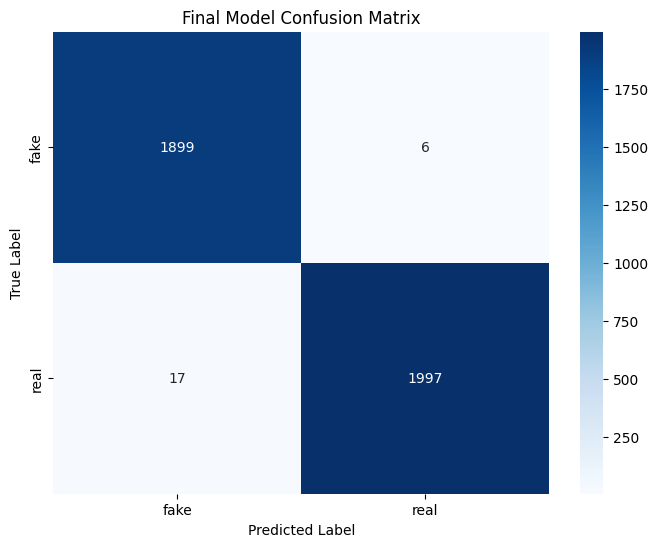

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# --- 1. Configuration ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATA_DIR = 'frames_ultimate_subset/train'
# --- IMPORTANT: Update this path ---
MODEL_PATH = 'deepfake_detector_ultimate_model.pth'
BATCH_SIZE = 32

# --- 2. Prepare Validation Data ---
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(DATA_DIR, val_transforms)
class_names = full_dataset.classes
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- 3. Load the Trained Model ---
model = models.efficientnet_b0()
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)
model.eval()

# --- 4. Get Predictions ---
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in tqdm(val_dataloader, desc="Evaluating final model"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 5. Display Metrics ---
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Model Confusion Matrix')
plt.show()

In [ ]:
import torch
from torchvision import models, transforms
import cv2
from PIL import Image
import os

# --- 1. Configuration ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# --- IMPORTANT: Update this path ---
MODEL_PATH = 'deepfake_detector_ultimate_model.pth'
class_names = ['fake', 'real']

# --- 2. Load the Model ---
model = models.efficientnet_b0()
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# --- 3. Prediction Function (using the same one as before) ---
inference_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_video(video_path, frame_interval=30):
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return
    predictions = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        if cap.get(cv2.CAP_PROP_POS_FRAMES) % frame_interval == 0:
            pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            image_tensor = inference_transforms(pil_image).unsqueeze(0).to(device)
            with torch.no_grad():
                outputs = model(image_tensor)
                _, pred_idx = torch.max(outputs, 1)
                predictions.append(pred_idx.item())
    cap.release()

    if not predictions:
        print("Could not extract any frames.")
        return

    fake_count = predictions.count(class_names.index('fake'))
    real_count = len(predictions) - fake_count
    fake_percentage = (fake_count / len(predictions)) * 100

    print(f"\n--- Final Prediction for: {os.path.basename(video_path)} ---")
    verdict = "FAKE" if fake_count > real_count else "REAL"
    confidence = fake_percentage if verdict == "FAKE" else 100 - fake_percentage

    if verdict == "FAKE":
        print(f'Verdict: ৯০% The video is likely FAKE ({confidence:.2f}% confidence)')
    else:
        print(f'Verdict: ✅ The video is likely REAL ({confidence:.2f}% confidence)')

# --- 4. RUN THE TEST ---
# --- IMPORTANT: Update this path to your Instagram Reel video ---
video_to_test = "/content/173239-848944192_small.mp4"
predict_video(video_to_test)


--- Final Prediction for: 173239-848944192_small.mp4 ---
Verdict: ✅ The video is likely REAL (100.00% confidence)
